In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy

import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from astropy.visualization import ZScaleInterval

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sep 
import tractor

import photutils

In [2]:
import kungpao

from kungpao.display import random_cmap

### HSC Data

- We are using the HSC `S21A` data release from internal release `DR4`.

In [ ]:
from unagi import hsc
from unagi import task
from unagi import query
from unagi import config
from unagi import catalog
from unagi import plotting

from unagi.task import hsc_tricolor

s21a = hsc.Hsc(dr='dr4', rerun='s21a_wide')

# Querying for the table list and save it to /Users/song/Dropbox/work/project/unagi/unagi/data/s21a_wide/s21a_wide_tables.fits


In [ ]:
out_dir = '/Users/song/Desktop/tractor/'

### Galaxies

- Will pick two galaxies from the HSC survey to test:
    - An "easy" one: α=158.283692° δ=-0.659077°
    - A "tough" one: α=158.332575° δ=-0.601713°
    
- These galaxies are from a messy part of the sky with a lot of Galactic cirrus and stars.

#### The easy one

# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i


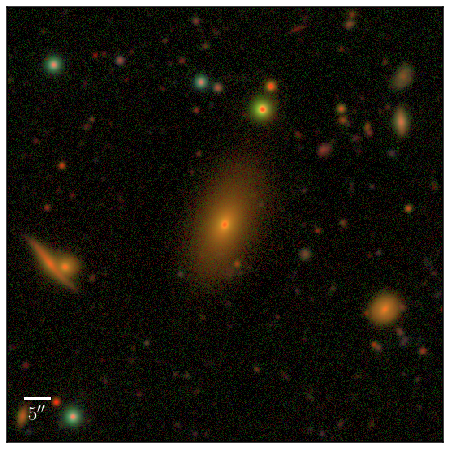

In [9]:
coord_1 = SkyCoord(158.283692, -0.659077, frame='icrs', unit='deg')

# Cutout size in arcsec
# HSC pixel size is 0.176 arcsec / pix
cutout_size = 45 * u.arcsec

filters = 'gri'

cutout_rgb, cutout_wcs = hsc_tricolor(
    coord_1, cutout_size=cutout_size, filters=filters, verbose=True, 
    save_rgb=False, save_img=False, use_saved=False, archive=s21a)

_ = plotting.display_single(cutout_rgb)

#### The tough one

# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i


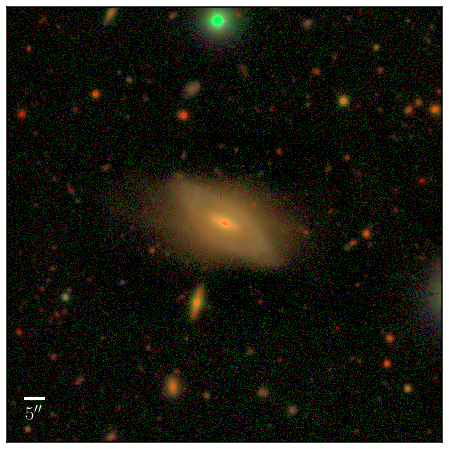

In [10]:
coord_2 = SkyCoord(158.332575, -0.601713, frame='icrs', unit='deg')

# Cutout size in arcsec
# HSC pixel size is 0.176 arcsec / pix
cutout_size = 60 * u.arcsec

cutout_rgb, cutout_wcs = hsc_tricolor(
    coord_2, cutout_size=cutout_size, filters=filters, verbose=True, 
    save_rgb=False, save_img=False, use_saved=False, archive=s21a)

_ = plotting.display_single(cutout_rgb)

## Galaxy 1: Isolated elliptical galaxies

# Read in saved FITS file: /Users/song/Desktop/tractor/tractor_test_1_i.fits
# Retrieving coadd PSF model in filter: i


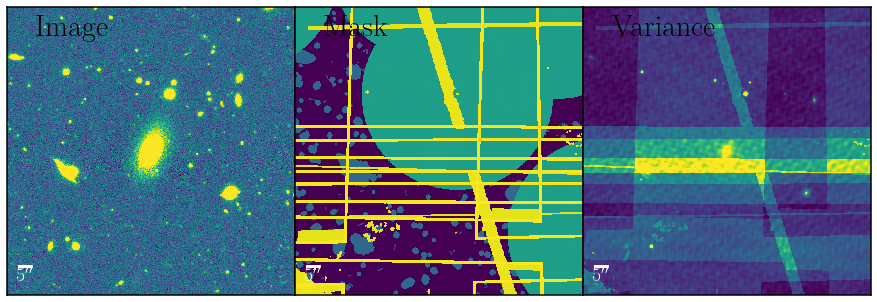

In [22]:

gal_1_i = task.hsc_cutout(coord_1, cutout_size=cutout_size, filters='i', archive=s21a, 
                          use_saved=True, output_dir=out_dir, verbose=True, 
                          save_output=True, variance=True, mask=True, prefix='tractor_test_1')

psf_1_i = task.hsc_psf(coord_1, filters='i', archive=s21a, save_output=True, 
                       output_dir=out_dir, prefix='tractor_test_1_psf', use_saved=False)[0].data


label_list = [r"$\rm {}$".format(label) for label in ['Image', 'Mask', 'Variance']]

_ = plotting.display_all(
    gal_1_i, hdu_list=True, img_size=4, label_list=label_list, fontsize=30, fontcolor='k')

# Detect 173 objects


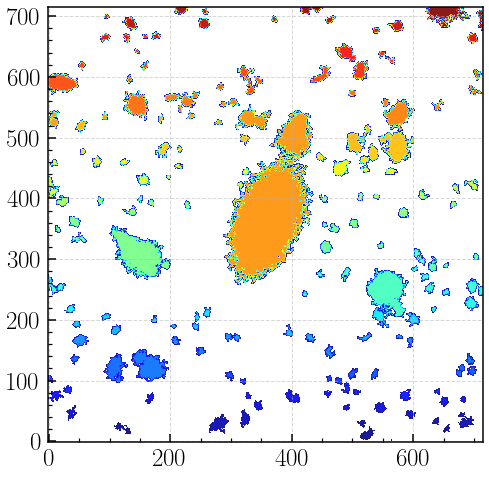

In [25]:
obj_1_i, seg_1_i = sep.extract(
    gal_1_i[1].data.byteswap().newbyteorder(), 1.5, 
    var=gal_1_i[3].data.byteswap().newbyteorder(), minarea=10, 
    deblend_nthresh=24, deblend_cont=0.8, clean=True, clean_param=1.0, segmentation_map=True)

seg_mask = seg_1_i > 0

print("# Detect %d objects" % len(obj_1_i))

plt.figure(figsize=(8, 8))

plt.imshow(seg_1_i, origin='lower', cmap=SEG_CMAP, vmin=1, alpha=0.9)

In [19]:
# Increase the box size a little to include objects just at the edge of the cutout
obj_1_i = task.hsc_box_search(
    coord_1, box_size=(cutout_size * 1.1), archive=s21a,
    verbose=True, psf=True, cmodel=True, aper=True, shape=True,
    meas='i', flux=False, aper_type='3_20')

# Select "clean" images
clean_1_i, mask_1_i = catalog.select_clean_objects(
    obj_1_i, return_catalog=True, verbose=True)

# WCS of the image
cutout_wcs = wcs.WCS(gal_1_i[1].header)

NameError: Wrong rerun name